# Detecting Issues in Tabular

### Data (Numeric/Categorical columns) with Datalab
`In this 5-minute quickstart tutorial, we use Datalab to detect various issues in a classification dataset with tabular (numeric/categorical) features. Tabular (or structured) data are typically organized in a row/column format and stored in a SQL database or file types like: CSV, Excel, or Parquet. Here we consider a Student Grades dataset, which contains over 900 individuals who have three exam grades and some optional notes, each being assigned a letter grade (their class label). cleanlab automatically identifies hundreds of examples in this dataset that were mislabeled with the incorrect final grade selected. You can run the same code from this tutorial to detect incorrect information in your own tabular classification datasets.`

#### Overview of what we'll do in this demo:
* Train a classifier model (here scikit-learn's HistGradientBoostingClassifier, although any model could be used) and use this classifier to compute (out-of-sample) predicted class probabilities via cross-validation.

* Create a K nearest neighbours (KNN) graph between the examples in the dataset.*

* Identify issues in the dataset with cleanlab's Datalab audit applied to the predictions and KNN graph.

In [1]:
import random
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors

from cleanlab import Datalab

SEED = 42  # for reproducibility
np.random.seed(SEED)
random.seed(SEED)

In [38]:
# load and process data
df=pd.read_csv('./grades.csv')
df.head()

,stud_ID,exam_1,exam_2,exam_3,notes,letter_grade
0,390062,37.45,69.82,18.51,NaN,D
1,0cce35,95.07,53.61,54.19,late submission -5,C
2,8cd0a4,73.20,30.95,87.29,absent once,C
3,7d6277,59.87,81.38,73.22,late submission -5,C
4,7248ad,15.60,68.47,80.66,great participation +10,D


In [3]:
df.shape

(500, 6)

In [40]:
print(sum(df.duplicated()))

0


In [41]:
x_raw=df[["exam_1", "exam_2", "exam_3", "notes"]]
labels=df["letter_grade"]

In [42]:
cat_cols=["notes"]
x_encoded=pd.get_dummies(x_raw,columns=cat_cols, drop_first=True)
num_features=["exam_1", "exam_2", "exam_3"]
scaler = StandardScaler()
x_processed=x_encoded.copy()
x_processed[num_features]=scaler.fit_transform(x_encoded[num_features])

In [43]:
x_processed

,exam_1,exam_2,exam_3,notes_bonus work +15,notes_excellent,notes_great participation +10,notes_late submission -5,notes_needs improvement
0,-0.415775,0.758215,-1.119782,False,False,False,False,False
1,1.515254,0.189858,0.081990,False,False,False,True,False
2,0.782321,-0.604650,1.196863,False,False,False,False,False
3,0.335590,1.163533,0.722958,False,False,False,True,False
4,-1.148038,0.710881,0.973552,False,False,True,False,False
...,...,...,...,...,...,...,...,...
495,-0.486488,-1.368654,0.507393,True,False,False,False,False
496,0.285320,1.526426,0.343362,False,False,False,False,False
497,-1.410446,-1.210173,-0.182077,False,False,False,False,False
498,1.594680,1.641781,-0.463995,False,False,True,False,False


### Select a classification model and compute out-of-sample predicted probabilities

In [44]:
clf=HistGradientBoostingClassifier()

In [45]:
num_crossval_folds=5
pred_probs=cross_val_predict(
    clf,
    x_processed,
    labels,
    cv=num_crossval_folds,
    method="predict_proba"

)

### Construct K nearest neighbours graph
* To detect outliers: isolated points will have large distances to their neighbors.

* To find clusters: similar points will connect densely.

* To support manifold learning (like t-SNE, UMAP, Isomap).

* For data validation: if some points don’t connect well, they may be errors.

In [46]:
from sklearn.neighbors import kneighbors_graph
KNN=NearestNeighbors(metric='euclidean')
KNN.fit(x_processed.values)
KNN_graph = kneighbors_graph(X, n_neighbors=3, mode='connectivity')

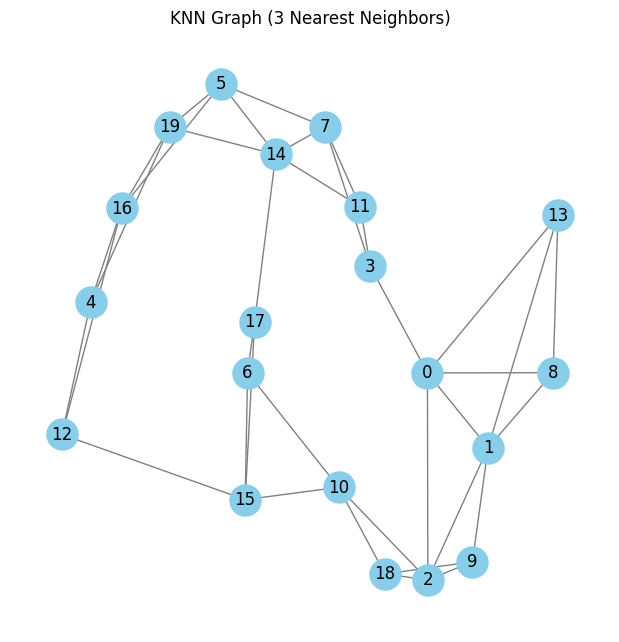

In [47]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
X, _ = make_moons(n_samples=20, noise=0.1, random_state=42)
G = nx.from_scipy_sparse_array(KNN_graph)

# Plot
plt.figure(figsize=(6, 6))
pos = {i: X[i] for i in range(len(X))}  # use original coordinates
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", edge_color="gray")
plt.title("KNN Graph (3 Nearest Neighbors)")
plt.show()

### Use cleanlab to find label issues

In [ ]:
data = {"X": x_processed.values, "letter_grade": labels}

lab = Datalab(data, label_name="letter_grade")
lab.find_issues(pred_probs=pred_probs, knn_graph=KNN_graph)

In [ ]:
lap.report()

### Label issues

In [ ]:
issue_results = lab.get_issues("label")
issue_results.head()

In [ ]:
sorted_issues = issue_results.sort_values("label_score").index

X_raw.iloc[sorted_issues].assign(
    given_label=labels.iloc[sorted_issues],
    predicted_label=issue_results["predicted_label"].iloc[sorted_issues]
).head()

### Outlier issues

In [ ]:
outlier_results = lab.get_issues("outlier")
sorted_outliers= outlier_results.sort_values("outlier_score").index

X_raw.iloc[sorted_outliers].head()

### Near-duplicate issues

In [ ]:
duplicate_results = lab.get_issues("near_duplicate")
duplicate_results.sort_values("near_duplicate_score").head()

In [ ]:
duplicate_results[duplicate_results['is_near_duplicate_issue'] == True]

In [ ]:
# Identify the row with the lowest near_duplicate_score
lowest_scoring_duplicate = duplicate_results["near_duplicate_score"].idxmin()

# Extract the indices of the lowest scoring duplicate and its near duplicate sets
indices_to_display = [lowest_scoring_duplicate] + duplicate_results.loc[lowest_scoring_duplicate, "near_duplicate_sets"].tolist()

# Display the relevant rows from the original dataset
X_raw.iloc[indices_to_display]

In [ ]:
# Identify the next row not in the previous near duplicate set
second_lowest_scoring_duplicate = duplicate_results["near_duplicate_score"].drop(indices_to_display).idxmin()

# Extract the indices of the second lowest scoring duplicate and its near duplicate sets
next_indices_to_display = [second_lowest_scoring_duplicate] + duplicate_results.loc[second_lowest_scoring_duplicate, "near_duplicate_sets"].tolist()

# Display the relevant rows from the original dataset
X_raw.iloc[next_indices_to_display]

# Spending too much time on data quality?

In [ ]:
# Note: This cell is only for docs.cleanlab.ai, if running on local Jupyter or Colab, please ignore it.

identified_label_issues = issue_results[issue_results["is_label_issue"] == True]
label_issue_indices = [3, 723, 709, 886, 689]  # check these examples were found in label issues
if not all(x in identified_label_issues.index for x in label_issue_indices):
    raise Exception("Some highlighted examples are missing from identified_label_issues.")

identified_outlier_issues = outlier_results[outlier_results["is_outlier_issue"] == True]
outlier_issue_indices = [3, 7, 0, 4, 8]  # check these examples were found in outlier issues
if not all(x in identified_outlier_issues.index for x in outlier_issue_indices):
    raise Exception("Some highlighted examples are missing from identified_outlier_issues.")

identified_duplicate_issues = duplicate_results[duplicate_results["is_near_duplicate_issue"] == True]
duplicate_issue_indices = [690, 246, 185, 582]  # check these examples were found in duplicate issues
if not all(x in identified_duplicate_issues.index for x in duplicate_issue_indices):
    raise Exception("Some highlighted examples are missing from identified_duplicate_issues.")

# check that the near duplicates shown are actually flagged as near duplicate sets
if not duplicate_results.iloc[690]["near_duplicate_sets"] == 246:
    raise Exception("These examples are not in the same near duplicate set")

if not duplicate_results.iloc[185]["near_duplicate_sets"] == 582:
    raise Exception("These examples are not in the same near duplicate set")

# Function to check if all rows are identical
def are_rows_identical(df):
    first_row = df.iloc[0]
    return all(df.iloc[i].equals(first_row) for i in range(1, len(df)))

# Test to ensure all displayed rows are identical
if not are_rows_identical(X_raw.iloc[indices_to_display]):
    raise Exception("Not all rows are identical! These examples should belong to the same EXACT duplicate set")

# Repeat the test for the next set of indices
if not are_rows_identical(X_raw.iloc[next_indices_to_display]):
    raise Exception("Not all rows are identical! These examples should belong to the same EXACT duplicate set")